# Bayes-by-Backprop (BBB)
Paper:
Weight Uncertainty in Neural Networks

Team members:
Shyana ?
Emma Krause
Stephen Holtz
Chong Guo

## Why BBB?

Neural networks are able to model extremely complex problems and generate accurate predictions. Nevertheless, in many real world applications we want a prediction and the confidence associated with that prediction. BBB accomplishes this by doing a varitional approximation to a full Bayesian inference on the networks weights. At inference time, the weights can simply be sampled to generate a post-predictive distribution from which the confidence of the prediction can be infered. 

## Deriving the update rule for BBB

BBB view a neural network as a probablistic model $p(D,w)$. The parameters are typically estimated using MLE by maximizing $p(D|w)$ or MAP, which uses a prior $p(w)$ to regularize the weights. 

$$

$$

In [1]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

import scipy as sp
import sklearn
import seaborn as sns
import time 

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('default')

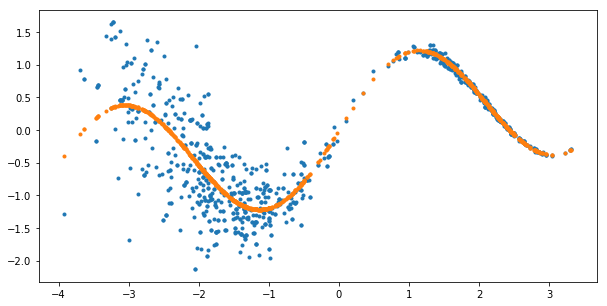

In [12]:
def gen_regress():
    Sig_x_mix = [0.8,0.5]  #[2,.5]
    Mu_x_mix = [-1.7,2]  #[-2.5,2]
    p_x = 0.6          # probability of cluster 1
    n_x  = 1000        # total number of samples in x
    # randomly generate cluster identity
    n_x_id = np.random.binomial(n_x,p_x) 
    n_x_id = [n_x_id,n_x-n_x_id]
    # sample x from a gaussian mixture
    x0 = np.random.randn(n_x_id[0],1)*Sig_x_mix[0]+Mu_x_mix[0]
    x1 = np.random.randn(n_x_id[1],1)*Sig_x_mix[1]+Mu_x_mix[1]
    x = np.concatenate((x0,x1))
    m_mu = 0.2
    m_sig = -1
    
    mu_y_func = lambda x,m: np.sin(x*1.5) + np.dot(x,m)
    sig_y_func = lambda x,m: 0.25*np.log(1+np.exp(np.dot(x,m)))
    y_mu = mu_y_func(x,m_mu)
    y_sig = sig_y_func(x,m_sig)
    y = y_mu+np.random.randn(n_x,1)*y_sig
    
    ridx = np.random.choice(range(n_x),n_x)
    x = x[ridx,:]
    y = y[ridx,:]
    y_mu = y_mu[ridx,:]
    y_sig = y_sig[ridx,:]
    
    return x,y,y_mu,y_sig

# plot the sample regression problem
x,y,y_mu,y_sig = gen_regress()

plt.figure(figsize=(10,5))
plt.plot(x,y,'.')
plt.plot(x,y_mu,'.')
plt.show()

We will use a MLP with a single non-linear hidden layer and a linear output to fit this data. First we demonstrate using normal gradient descent.

In [13]:
# a linear function
g = lambda x,m,b: np.dot(x,m) + b
# a tanh function and its derivative
f = lambda g: np.tanh(g)
dfdg = lambda g: 1.0 - np.tanh(g)**2
#f = lambda g: np.log(1+np.exp(g))
#dfdg = lambda g: 1/(1+np.exp(-g))


# now we define a simple MLP with one input n hidden and one output
class MLP():
    def __init__(self,nhidden,nbatch,alpha):
        self.nhidden = nhidden
        self.alpha = alpha
        # weight prior sigma
        self.w1_sig = 1;
        self.b1_sig = 1;
        self.w2_sig = 1;
        self.b2_sig = 1;
        # weight initialization
        self.w1 = np.random.randn(1,nhidden)
        self.b1 = np.random.randn(1,nhidden)
        self.w2 = np.random.randn(nhidden,1)
        self.b2 = np.random.randn(1,1)
        
        self.x = np.zeros((nbatch,1))
        self.z = np.zeros((nbatch,nhidden))
        self.h = np.zeros((nbatch,nhidden))
        self.y = np.zeros((nbatch,1))
        
    def forward(self,x):
        self.x = x
        self.z = g(self.x,self.w1,self.b1)
        self.h = f(self.z)
        self.y = g(self.h,self.w2,self.b2)
        return self.y
    
    def predict(self,x):
        z = g(x,self.w1,self.b1)
        h = f(z)
        y = g(h,self.w2,self.b2)
        return y
        
    def backward(self,y_target):
        dy = self.y-y_target
        dw2 = np.dot(dy.T,self.h).T
        db2 = np.sum(dy,0)
        dz = np.outer(dy,self.w2.T)*dfdg(self.z)
        dw1 = np.dot(dz.T,self.x).T
        db1 = np.sum(dz,0)
        
        self.w1 += -self.alpha*(dw1+self.w1/self.w1_sig)
        self.b1 += -self.alpha*(db1+self.b1/self.b1_sig)
        self.w2 += -self.alpha*(dw2+self.w2/self.w2_sig)
        self.b2 += -self.alpha*(db2+self.b2/self.b2_sig)
        
        err = np.sum(dy**2)
        return err

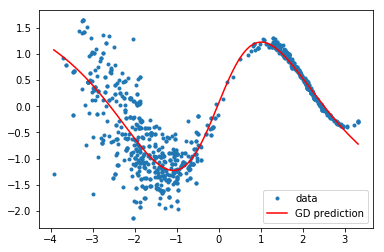

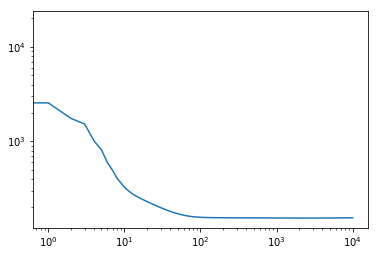

In [15]:
n = x.shape[0]
ws = []
#for rep in range(100):
net_GD = MLP(20,n,1e-4)
nepoch = 10000
err = np.zeros((nepoch,1))
for i in range(nepoch):
    net_GD.forward(x)
    err[i] = net_GD.backward(y)
    
x_grid = np.linspace(np.min(x),np.max(x),1000).reshape((1000,-1))
y_pred = net_GD.predict(x_grid)
plt.plot(x,y,'.',label='data')
plt.plot(x_grid,y_pred,'r',label='GD prediction')
plt.legend()
plt.show()

plt.plot(err)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [16]:
sr = lambda x: np.log(1+np.exp(x))+1e-8
dsr= lambda x: 1/(1+np.exp(-x))+1e-8

class MLP_BBB():
    def __init__(self,nhidden,nbatch,alpha):
        self.nhidden = nhidden
        self.alpha = alpha
        # weight prior sigma
        self.w1_mu_sig = 1;
        self.b1_mu_sig = 1;
        self.w2_mu_sig = 1;
        self.b2_mu_sig = 1;
        self.w1_pi_sig = 1;
        self.b1_pi_sig = 1;
        self.w2_pi_sig = 1;
        self.b2_pi_sig = 1;
        # initialize the parameters both in terms of mu and sigma
        self.w1_mu = np.random.randn(1,nhidden)
        self.b1_mu = np.random.randn(1,nhidden)
        self.w2_mu = np.random.randn(nhidden,1)
        self.b2_mu = np.random.randn(1,1)
        self.w1_pi = np.random.randn(1,nhidden)
        self.b1_pi = np.random.randn(1,nhidden)
        self.w2_pi = np.random.randn(nhidden,1)
        self.b2_pi = np.random.randn(1,1)
        
        self.w1 = np.random.randn(1,nhidden)
        self.b1 = np.random.randn(1,nhidden)
        self.w2 = np.random.randn(nhidden,1)
        self.b2 = np.random.randn(1,1)
        
        self.w1_e = np.random.randn(1,nhidden)
        self.b1_e = np.random.randn(1,nhidden)
        self.w2_e = np.random.randn(nhidden,1)
        self.b2_e = np.random.randn(1,1)
        
        self.x = np.zeros((nbatch,1))
        self.z = np.zeros((nbatch,nhidden))
        self.h = np.zeros((nbatch,nhidden))
        self.y = np.zeros((nbatch,1))
        
    def forward(self,x):
        self.w1_e = np.random.randn(1,self.nhidden)
        self.b1_e = np.random.randn(1,self.nhidden)
        self.w2_e = np.random.randn(self.nhidden,1)
        self.b2_e = np.random.randn(1,1)
        self.w1 = self.w1_e*sr(self.w1_pi) + self.w1_mu
        self.b1 = self.b1_e*sr(self.b1_pi) + self.b1_mu
        self.w2 = self.w2_e*sr(self.w2_pi) + self.w2_mu
        self.b2 = self.b2_e*sr(self.b2_pi) + self.b2_mu
        
        self.x = x
        self.z = g(self.x,self.w1,self.b1)
        self.h = f(self.z)
        self.y = g(self.h,self.w2,self.b2)
        return self.y
    
    def predict(self,x):
        self.w1 = self.w1_mu
        self.b1 = self.b1_mu
        self.w2 = self.w2_mu
        self.b2 = self.b2_mu
        
        self.x = x
        self.z = g(self.x,self.w1,self.b1)
        self.h = f(self.z)
        self.y = g(self.h,self.w2,self.b2)
        return self.y
    
    def confidence(self,x,nsim):
        y_sim = np.zeros((x.shape[0],nsim))
        for i in range(nsim):
            y_sim[:,i] = self.forward(x)[:,0]
        y_std = np.std(y_sim,1).reshape([x.shape[0],-1])
        return y_sim, y_std
    
    def backward(self,y_target):
        dy = self.y-y_target
        dw2 = np.dot(dy.T,self.h).T
        db2 = np.sum(dy,0)
        dz = np.outer(dy,self.w2.T)*dfdg(self.z)
        dw1 = np.dot(dz.T,self.x).T
        db1 = np.sum(dz,0)
        
        self.w1_mu += -self.alpha*(dw1+self.w1_mu/self.w1_mu_sig+self.w1_e/sr(self.w1_pi))
        self.b1_mu += -self.alpha*(db1+self.b1_mu/self.b1_mu_sig+self.b1_e/sr(self.b1_pi))
        self.w2_mu += -self.alpha*(dw2+self.w2_mu/self.w2_mu_sig+self.w2_e/sr(self.w2_pi))
        self.b2_mu += -self.alpha*(db2+self.b2_mu/self.b2_mu_sig+self.b2_e/sr(self.b2_pi))
        self.w1_pi += -self.alpha*((dw1+self.w1_pi/self.w1_pi_sig)*dsr(self.w1_pi)*self.w1_e+(self.w1_e**2-1)/sr(self.w1_pi)*dsr(self.w1_pi))
        self.b1_pi += -self.alpha*((db1+self.b1_pi/self.b1_pi_sig)*dsr(self.b1_pi)*self.b1_e+(self.b1_e**2-1)/sr(self.b1_pi)*dsr(self.b1_pi))
        self.w2_pi += -self.alpha*((dw2+self.w2_pi/self.w2_pi_sig)*dsr(self.w2_pi)*self.w2_e+(self.w2_e**2-1)/sr(self.w2_pi)*dsr(self.w2_pi))
        self.b2_pi += -self.alpha*((db2+self.b2_pi/self.b2_pi_sig)*dsr(self.b2_pi)*self.b2_e+(self.b2_e**2-1)/sr(self.b2_pi)*dsr(self.b2_pi))
        
        err = np.sum(dy**2)
        return err

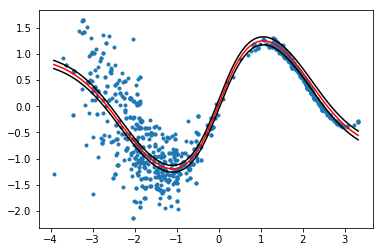

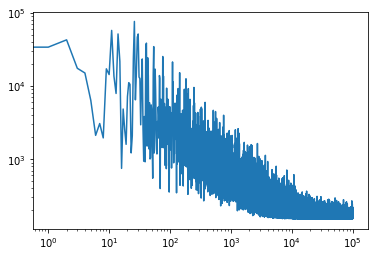

In [17]:
n = x.shape[0]
net_BBB = MLP_BBB(20,n,5e-5)
nepoch = 100000
err = np.zeros((nepoch,1))
for i in range(nepoch):
    net_BBB.forward(x)
    err[i] = net_BBB.backward(y)

x_grid = np.linspace(np.min(x),np.max(x),1000).reshape((1000,-1))
y_pred = net_BBB.predict(x_grid)
y_ppc,y_std = net_BBB.confidence(x_grid,100)

plt.plot(x,y,'.')
plt.plot(x_grid,y_pred,'r')
plt.plot(x_grid,y_pred-y_std,'k')
plt.plot(x_grid,y_pred+y_std,'k')
plt.show()
plt.plot(err)
plt.yscale('log')
plt.xscale('log')
plt.show()

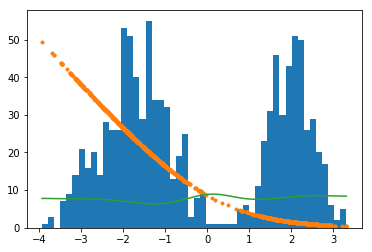

In [18]:
plt.hist(x,50)
plt.plot(x,y_sig*50,'.')
plt.plot(x_grid,(y_std)*100)
plt.show()